<a href="https://colab.research.google.com/github/omkarsk98/NewsDataClassification/blob/development/NewsDataClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the repo for original and raw csv data

In [1]:
!git clone https://github.com/omkarsk98/NewsDataClassification.git

Cloning into 'NewsDataClassification'...
remote: Enumerating objects: 101, done.
remote: Total 101 (delta 0), reused 0 (delta 0), pack-reused 101
Receiving objects: 100% (101/101), 10.11 MiB | 10.13 MiB/s, done.
Resolving deltas: 100% (48/48), done.


Go the directory and checkout to the required folder

In [2]:
%cd NewsDataClassification
!git checkout development

/content/NewsDataClassification
Branch 'development' set up to track remote branch 'development' from 'origin'.
Switched to a new branch 'development'


Download trained model and unzip it.

In [3]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip GoogleNews-vectors-negative300.bin.gz

--2020-10-29 16:36:05--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.84.206
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.84.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  34.8MB/s    in 46s     

2020-10-29 16:36:51 (34.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



Download nltk libraries and dependencies

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

import all required libraries

In [7]:
import pandas as pd
from gensim import models
from sklearn.linear_model import LogisticRegression
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score ,confusion_matrix
import time
from sklearn.manifold import TSNE
from google.colab import files

In [8]:
# Load word2vec model (trained on Google's corpus)
model = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 
# Check dimension of word vectors
print("Dimensions of the model",model.vector_size)

Dimensions of the model 300


Read the raw data and set max records to be used

In [9]:
# read csv
main_data = pd.read_csv('News_Final.csv')

# read titles from it
article_titles = main_data['TITLE']
labels = main_data["CATEGORY"]

# Create a list of strings, one for each title
titles_list = [title for title in article_titles]
# form a single string fro the list of strings
big_title_string = ' '.join(titles_list)

# define total records to be considered for analysis
total = 100000
# 422178 total records as max value

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Tokenise all words and get stop words for english

In [10]:
# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]
stop_words = set(stopwords.words('english'))

Define all the function that can be used for later stage

In [11]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, labels, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)
    
    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]
    

    corpus = [doc for doc in corpus if condition_on_doc(doc)]
    
    final_labels = []
    for i in range(len(corpus)):
      if condition_on_doc(corpus[i]):
        final_labels.append(labels[i])
    
    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts, final_labels)

Remove stop words, non vocab words, empty docs and prepare vector for each title

In [12]:
# # Preprocess the corpus to get list of documents with stop words removed and containing only the words that are present in the vocab
corpus = [preprocess(title) for title in titles_list]
# # still contains all the documents, nothing is filtered

# # Remove docs that don't include any words in W2V's vocab
corpus, titles_list, labels = filter_docs(corpus, titles_list, labels, lambda doc: has_vector_representation(model, doc))
print("1st filter: Length of corpus:"+str(len(corpus))+", Length of titles_list:"+ str(len(titles_list))+", Length of labels:"+str(len(labels)))

# # Filter out any empty docs
corpus, titles_list, labels = filter_docs(corpus, titles_list, labels, lambda doc: (len(doc) != 0))
print("2nd filter: Length of corpus:"+str(len(corpus))+", Length of titles_list:"+ str(len(titles_list))+", Length of labels:"+str(len(labels)))

x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))

241 docs removed
1st filter: Length of corpus:422178, Length of titles_list:422178, Length of labels:422178
0 docs removed
2nd filter: Length of corpus:422178, Length of titles_list:422178, Length of labels:422178


# **After removing stop words and empty docs** <br>

---
241 docs removed <br>
1st filter: Length of corpus:422178, Length of titles_list:422178, Length of labels:422178 <br>
0 docs removed <br>
2nd filter: Length of corpus:422178, Length of titles_list:422178, Length of labels:422178 <br>

In [13]:
vectorsForEachDocument = np.array(x) # list to array
labels = np.array(labels)
labels = labels.reshape(labels.shape[0],1)
vectorsForEachDocument.shape, labels.shape

((422178, 300), (422178, 1))

# **Vectors for each title** 

---
A list of vectors of 300 dimensions each for all the titles and labels contain the respective labels<br>
Shape of these vectors is (422178, 300) <br>
Shape pf it respective labels (422178, 1)

# **Filter improper labels**

---
Filter out the data that has improper labels. Labels should only be of the following types. <br>
1. b: business
2. t: technology
3. e: entertainment
4. m: health

In [14]:
# filter out data that has improper labels
possibleLabels = ["b","t","e","m"]
finalLabels = []
features = []
for i in range(len(labels)):
  if labels[i] in possibleLabels:
    finalLabels.append(labels[i])
    features.append(vectorsForEachDocument[i])
  if(len(finalLabels)==total):
    break


features = np.array(features)
labels = np.array(finalLabels)
labels = labels.reshape(labels.shape[0],1)
features.shape, labels.shape

((100000, 300), (100000, 1))

# **Create a dataframe to shuffle it**

---
Create dataframe to shuffle it and split it.

In [15]:
finalData = pd.DataFrame.from_records(features)
finalData.columns = range(1,301)
finalData["labels"] = labels
# finalData.to_csv('FinalData.csv')
data = finalData.sample(frac=1) #shuffles the data
labels = data["labels"]
labels = np.array(labels) 
labels = labels.reshape(labels.shape[0],1)
del data["labels"]
features = np.array(data)
features.shape, labels.shape

((100000, 300), (100000, 1))

# Split the data
---
**Train Data**: Use 80% of the data for training purpose. <br>
**Test Data**: Use 20% of the data for testing purpose. <br>
**Features**: Use 300 dimensional vectors as features. It can be found in `vectorsForEachDocument`.<br>
**Labels**: Use the categories as labels. I can be found in `labels`.<br>

In [16]:
train = int((80/100)*len(features))
trainFeatures, testFeatures = features[:train], features[train:]
trainLabels, testLabels = labels[:train], labels[train:]
trainFeatures.shape, trainLabels.shape, testFeatures.shape, testLabels.shape

((80000, 300), (80000, 1), (20000, 300), (20000, 1))

**Shapes of the data** <br>
trainFeatures: (160000,300) <br>
trainLabels: (160000,1) <br>
testFeatures: (40000,300) <br>
testLabels: (40000,1) <br>

# **Train the logistic regression model** <br>

In [17]:
tic = time.time()
logistic_Regression = LogisticRegression(multi_class="auto", solver="lbfgs", max_iter=1000)
logistic_Regression.fit(trainFeatures,trainLabels)
Y_predict = logistic_Regression.predict(testFeatures)
print(str((accuracy_score(testLabels,Y_predict)*100))+"%")
toc = time.time()
print("Time taken:"+str(toc-tic)+" seconds")

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


82.81500000000001%
Time taken:19.450258016586304 seconds


# **Outcomes of the training** <br>

---
|Train |Test |Dimensions |Accuracy |Time(sec) | Comments |
|---|---|---|---|---|---|
|40000|10000|300|86|12|Data randomly shuffled|
|80000|20000|300|78|53||
|40000|10000|300|74|12||
|80000|20000|300|78|53||
|24000|6000|300|73|11||
|160000|40000|300|72|53||
|80000|20000|300|82.8|19.4|Data randomly shuffled|

**Precision and recall**

---
Calculating precision and recall using sklearn.metrics.precision_recall_fscore_support.<br>
Precision is the fraction of relevant instances among the retrieved instances, while recall is the fraction of the total amount of relevant instances that were actually retrieved.



In [19]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(testLabels, Y_predict, labels=possibleLabels)
print("For labels in sequence as",possibleLabels)
print('precision: {}'.format(precision*100))
print('recall: {}'.format(recall*100))

For labels in sequence as ['b', 't', 'e', 'm']
precision: [79.39574917 80.34613089 87.08965517 83.25123153]
recall: [81.35349172 77.82273603 90.94051563 73.12851579]


**Result of precision and recall**

---

For labels in sequence as ['b', 't', 'e', 'm'] <br>
precision: [82.94729775 83.25883787 89.44781729 87.46594005] <br>
recall: [84.79752917 80.92417062 91.4843288  82.16723549] <br>

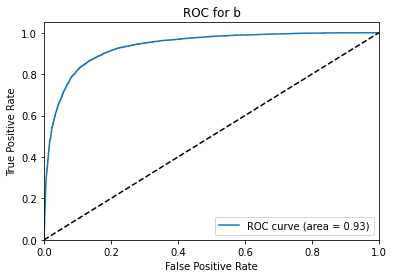

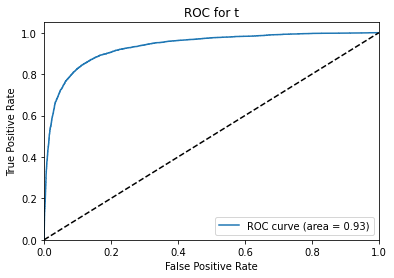

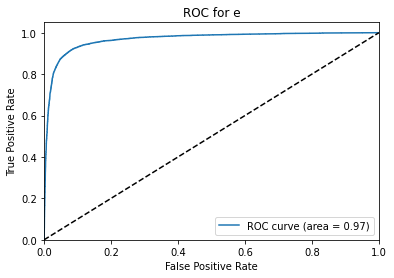

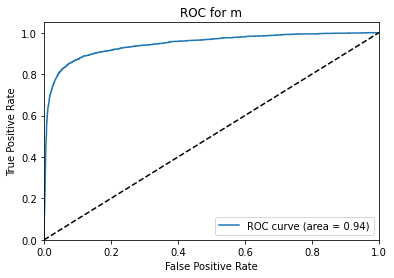

In [20]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

testLabelsBinary = label_binarize(testLabels, classes=possibleLabels)
trainLabelsBinary = label_binarize(trainLabels, classes=possibleLabels)

# classifier
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
y_score = clf.fit(trainFeatures, trainLabelsBinary).decision_function(testFeatures)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(testLabelsBinary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title = 'ROC for '+possibleLabels[i]
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
